# MHA MQA GQA MLA
## MHA

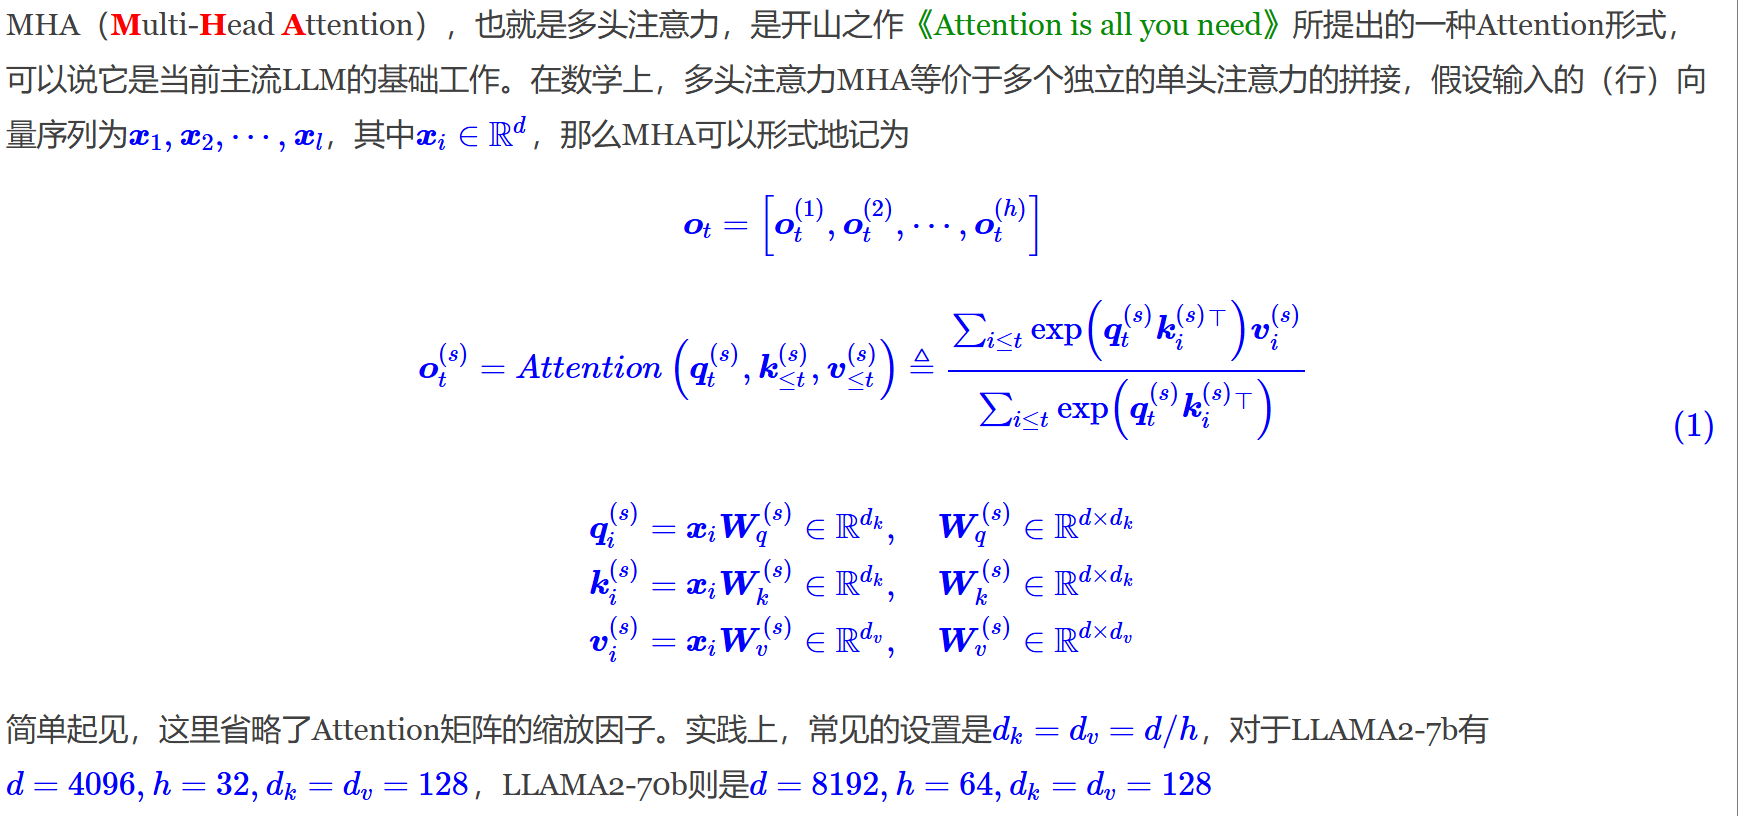

In [5]:
import torch
from torch import nn
import math
import torch.nn.functional as F
from typing import Optional

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model: int, nums_head: int, dropout: float=0.1):
        super().__init__()
        if d_model % nums_head != 0:
            assert ValueError(f"d_model {d_model} must can be dived by head {nums_head}")
        self.head_dim = d_model // nums_head
        self.nums_head = nums_head
        self.q_proj = nn.Linear(d_model, d_model)
        self.k_proj = nn.Linear(d_model, d_model)
        self.v_proj = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)
        self.o_proj = nn.Linear(d_model, d_model)

    def forward(self, x: torch.Tensor, attention_mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        batch_size, seq_len, d_model = x.size()  # (batch_size, seq_len, d_model)

        Q = self.q_proj(x)  # (batch_size, seq_len, d_model) 
        K = self.k_proj(x)  # (batch_size, seq_len, d_model)
        V = self.v_proj(x)  # (batch_size, seq_len, d_model)

        q_state = Q.view(batch_size, seq_len, self.nums_head, self.head_dim).permute(0,2,1,3)  # (batch_size, nums_head, seq_len, head_dim)
        k_state = K.view(batch_size, seq_len, self.nums_head, self.head_dim).permute(0,2,3,1)  # (batch_size, nums_head, head_dim, seq_len)
        v_state = V.view(batch_size, seq_len, self.nums_head, self.head_dim).permute(0,2,1,3)  # (batch_size, nums_head, seq_len, head_dim)

        attention_weight = q_state @ k_state / math.sqrt(self.head_dim)

        if attention_mask is not None:
            attention_weight = attention_weight.masked_fill(attention_mask == 0, float("-1e9"))
        
        attention_weight = F.softmax(attention_weight, dim=3)
        attention_weight = self.dropout(attention_weight)

        output_mid = attention_weight @ v_state
        output_mid = output_mid.transpose(1,2).contiguous()  # (batch_size, seq_len, nums_head, head_dim) 

        output = output_mid.view(batch_size, seq_len, -1)
        output = self.o_proj(output)

        return output

d_model = 512
nums_head = 8
batch_size = 8
x = torch.randn(batch_size,4,d_model)
model = MultiHeadAttention(d_model=d_model, nums_head=nums_head)
output = model(x)
print(output.size())


torch.Size([8, 4, 512])


## MQA
对于每一层的所有注意力头共享一个k和v。
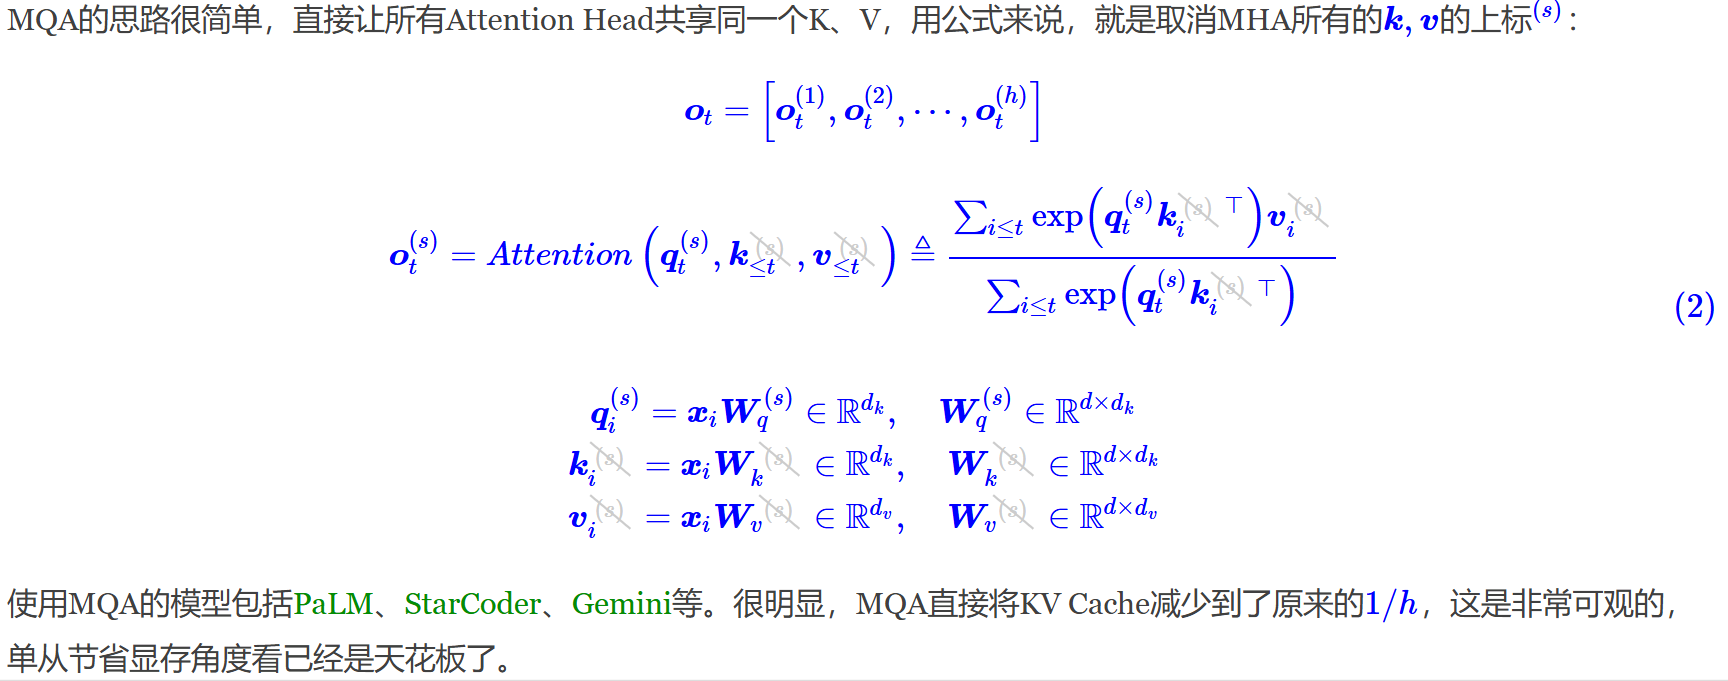

## GQA

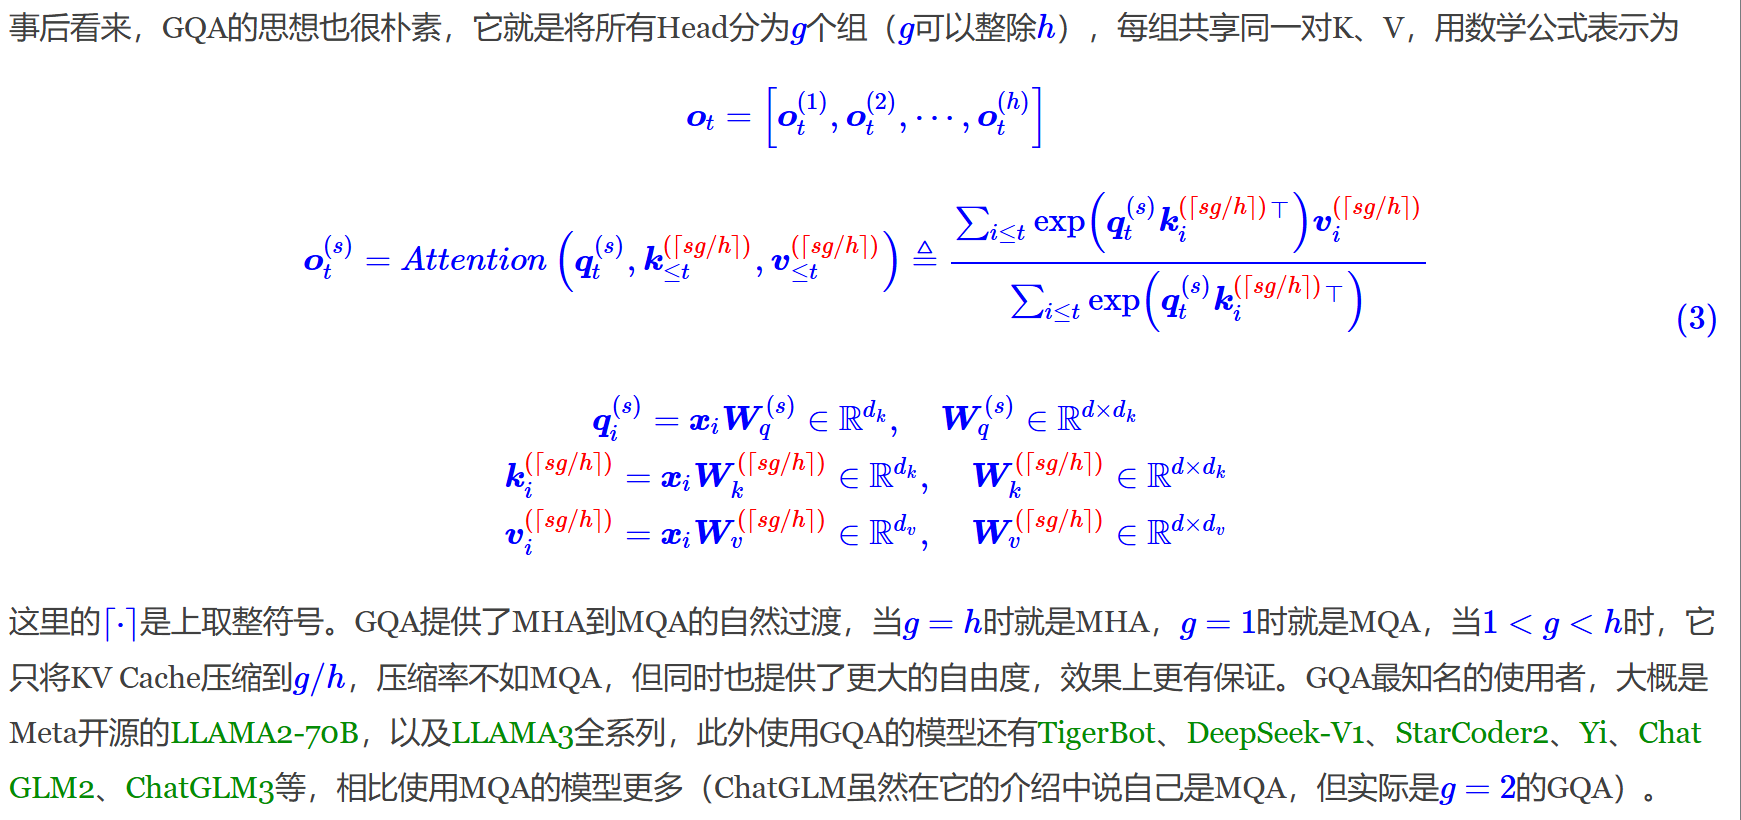

In [8]:
import torch
from torch import nn
import math
import torch.nn.functional as F
from typing import Optional

class GroupedQueryAttention(nn.Module):
    def __init__(self, d_model: int, nums_head: int, nums_key_value_head: int, dropout: float=0.1):
        super().__init__()

        # 判断查询头数量、键值头数量参数是否正确
        assert d_model % nums_head == 0, ValueError(f"d_model {d_model} must can be dived by nums_head {nums_head}")
        assert nums_head % nums_key_value_head == 0, ValueError(f"nums_head {nums_head} must can be dived by nums_group {nums_key_value_head}")
        
        self.nums_head = nums_head
        self.nums_key_value_head = nums_key_value_head
        self.head_dim = d_model // nums_head
        self.heads_per_group = nums_head // nums_key_value_head
        
        # 定义投影矩阵
        self.q_proj = nn.Linear(d_model, d_model)
        self.k_proj = nn.Linear(d_model, nums_key_value_head * self.head_dim)
        self.v_proj = nn.Linear(d_model, nums_key_value_head * self.head_dim)

        # 输出层和Dropout
        self.dropout = nn.Dropout(dropout)
        self.o_proj = nn.Linear(d_model, d_model)

    def forward(self, x:torch.Tensor, attention_mask: Optional[torch.Tensor]=None) -> torch.Tensor:
        """GQA注意力机制

        Args:
            x (torch.Tensor): (batch_size, seq_len, d_model)
            attention_mask (Optional[torch.Tensor]): (batch_size, seq_len, d_model) default is None

        Returns:
            torch.Tensor: (batch_size, seq_len, d_model)
        """
        batch_size, seq_len, d_model = x.size()

        # 生成Q, K, V
        q = self.q_proj(x).view(batch_size, seq_len, self.nums_head, self.head_dim)  # (batch_size, seq_len, nums_head, d_model)
        k = self.k_proj(x).view(batch_size, seq_len, self.nums_key_value_head, self.head_dim)  # (batch_size, seq_len, nums_group, d_model)
        v = self.v_proj(x).view(batch_size, seq_len, self.nums_key_value_head, self.head_dim)  # (batch_size, seq_len, nums_group, d_model)

        # 扩展k和v的头数以匹配q
        k = k.repeat_interleave(self.heads_per_group, dim=2)
        v = v.repeat_interleave(self.heads_per_group, dim=2)

        # 调整维度用于注意力计算
        q = q.transpose(1, 2)  # [B, H, L, D]
        k = k.transpose(1, 2)  # [B, H, L, D]
        v = v.transpose(1, 2)  # [B, H, L, D]

        # 计算注意力分数
        attn_source = q @ k.transpose(-2, -1) / math.sqrt(self.head_dim)

        # 应用注意力掩码
        if attention_mask is not None:
            attn_source = attn_source.masked_fill(attention_mask==0, float("-1e9"))
        
        # 计算注意力权重
        attn_weight = F.softmax(attn_source, dim=-1)
        attn_weight = self.dropout(attn_weight)

        # 计算上下文表示
        attn_output = attn_weight @ v  # [B, H, L, D]

        # 合并多头输出
        attn_output = attn_output.transpose(1,2).contiguous()
        attn_output = attn_output.view(batch_size, seq_len, -1)
        attn_output = self.o_proj(attn_output)

        return attn_output, attn_weight
    
# 参数配置
embed_dim = 512
num_heads = 8
num_groups = 2
batch_size = 4
seq_len = 32

# 初始化GQA模块
gqa = GroupedQueryAttention(embed_dim, num_heads, num_groups)

# 随机输入数据
x = torch.randn(batch_size, seq_len, embed_dim)

# 前向传播
output, weights = gqa(x)
print(output.shape)  # [4, 32, 512]
print(weights.shape) # [4, 8, 32, 32]

torch.Size([4, 32, 512])
torch.Size([4, 8, 32, 32])


## MLA
本质上是对经过投影网矩阵的qkv在经过各自的投影矩阵，增强表征能力。为了保留位置信息（RoPE位置编码方式），额外增加了一个维度。详细信息参考苏剑林的博客

训练阶段：

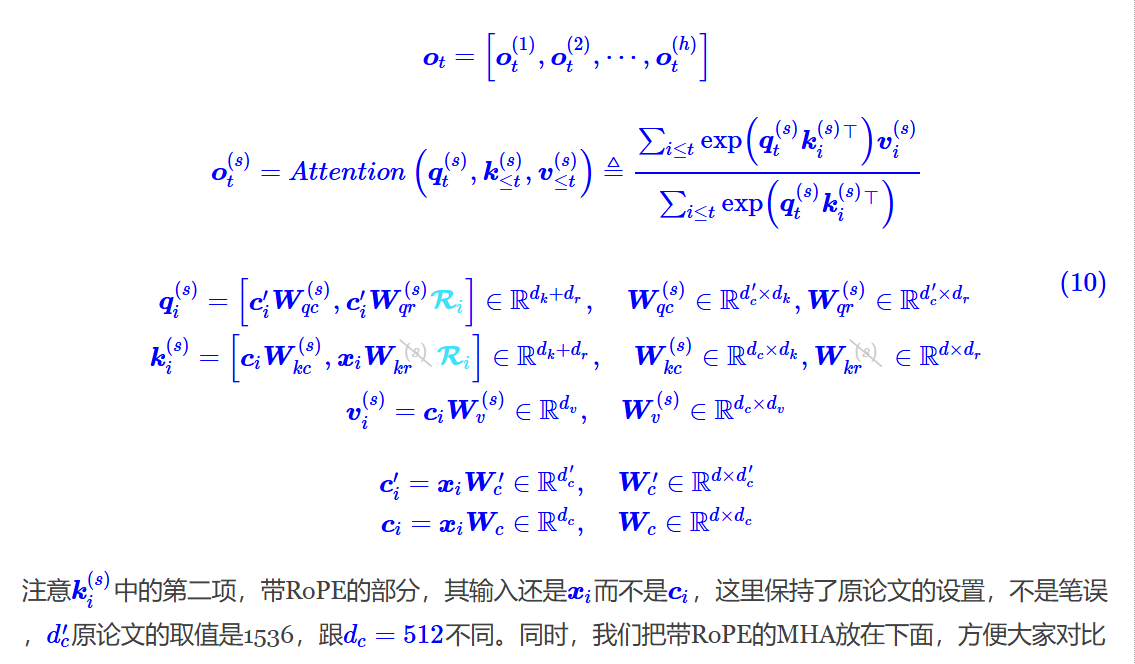

推理阶段,缓存$c_i$ 和 $x_i * W_{kr} * R_i$：

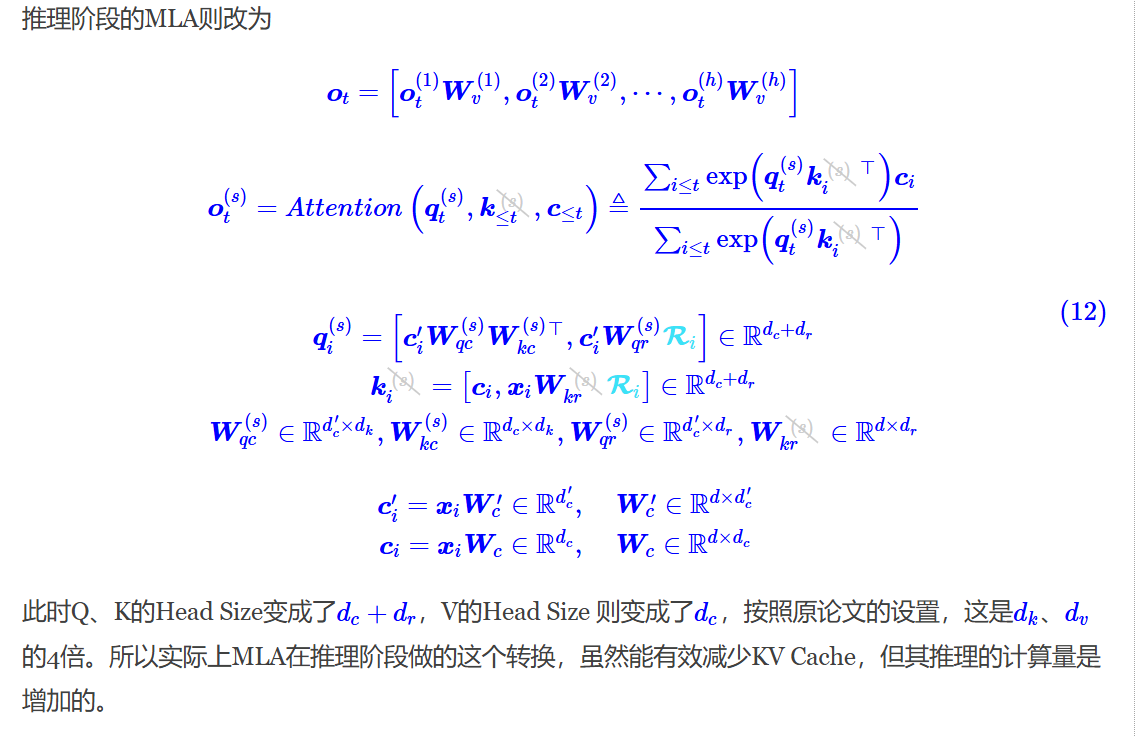

## 参考资料
[手写大模型组件之Group Query Attention，从 MHA，MQA 到 GQA](https://bruceyuan.com/hands-on-code/hands-on-group-query-attention-and-multi-query-attention.html#group-query-attention "代码实现")

[缓存与效果的极限拉扯：从MHA、MQA、GQA到MLA](https://spaces.ac.cn/archives/10091 "苏剑林,理论推导")